# Mapping migration

Introduction to vector data operations

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [1]:
%store -r eco_gdf gbif_gdf

In [2]:
# Import needed Python libraries

# Python Standard Library Packages
import os
import pathlib

# Other Packages
import earthpy # Manage local data
import pandas as pd # Work with tabular data
import geopandas as gpd # Work with geospatial vector data
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point


/Users/agregory/Desktop/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/earthpy/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


:::

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out the <a
href="https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins"><code>geopandas</code>
documentation on spatial joins</a> to help you figure this one out. You
can also ask your favorite LLM (Large-Language Model, like ChatGPT)</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Perform a spatial join</div></div><div class="callout-body-container callout-body"><p>Identify the correct values for the <code>how=</code> and
<code>predicate=</code> parameters of the spatial join.</p></div></div>

EPSG:4326
EPSG:4326
            month                    geometry
gbifID                                       
4158712344      5    POINT (-82.5092 41.9137)
4923515059      5  POINT (-87.61172 41.85281)
4923522410      9  POINT (-87.61172 41.85281)
4923520798      5  POINT (-87.61172 41.85281)
4923520314      9  POINT (-87.63013 41.88036)
...           ...                         ...
4423534780      9    POINT (-75.1254 40.0626)
4524632357      6    POINT (-89.8049 44.6967)
4173211734      5    POINT (-82.4753 42.0478)
4173216429      6    POINT (-74.5468 46.1638)
4423531794      9    POINT (-75.1254 40.0626)

[165614 rows x 2 columns]
     OBJECTID                                           ECO_NAME  SHAPE_AREA  \
0         1.0                                 Adelie Land tundra    0.038948   
1         2.0             Admiralty Islands lowland rain forests    0.170599   
2         3.0  Aegean and Western Turkey sclerophyllous and m...   13.844952   
3         4.0                      

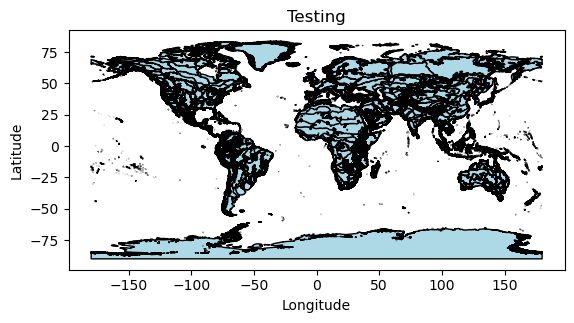

In [3]:
# Find out what CRS the data are in
print(eco_gdf.crs)

# Plot
eco_gdf.plot(
    color = "lightblue",
    edgecolor = "black"
)

# Give it labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Testing")

print(gbif_gdf.crs)

print(gbif_gdf)

print(eco_gdf)

In [4]:
gbif_ecoregion_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how = 'inner', 
        
        # only include ecoregions with gbif
        predicate='contains') # Using points and polygons

    # select columns we care about
    [['OBJECTID', 'month']]
    .rename(columns = {'OBJECTID': 'ecoregion'})
)
gbif_ecoregion_gdf


,ecoregion,month
12,13.0,5
12,13.0,5
12,13.0,6
12,13.0,7
12,13.0,6
...,...,...
839,845.0,9
839,845.0,9
839,845.0,9
839,845.0,9


### Count the observations in each ecoregion each month

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Group observations by ecoregion</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>columns_to_group_by</code> with a list of columns.
Keep in mind that you will end up with one row for each group – you want
to count the observations in each ecoregion by month.</li>
<li>Select only month/ecosystem combinations that have more than one
occurrence recorded, since a single occurrence could be an error.</li>
<li>Use the <code>.groupby()</code> and <code>.mean()</code> methods to
compute the mean occurrences by ecoregion and by month.</li>
<li>Run the code – it will normalize the number of occurrences by month
and ecoretion.</li>
</ol></div></div>

In [5]:
gbif_ecoregion_gdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162348 entries, 12 to 839
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ecoregion  162348 non-null  float64
 1   month      162348 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 3.7 MB


In [6]:
occurrence_df = (
    gbif_ecoregion_gdf

    # Ecoregions by month
    .groupby(['ecoregion', 'month'])

    # Count the number of occurrences
    .agg(occurrences=('ecoregion', 'count'))
)

# Get rid of rare observations 
occurrence_df = occurrence_df[occurrence_df.occurrences > 1] # Only include occurences wiht more than one recorded

# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ecoregion')
    .mean()
)
mean_occurrences_by_ecoregion

# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)
mean_occurrences_by_month

### summarize occurrences
occurrence_df = (
    gbif_ecoregion_gdf
    # # Select only necessary columns
    # [[]]
    # For each ecoregion, for each month...
    .groupby(['ecoregion', 'month'])
    # ...count the number of occurrences
    .agg(occurrences=('ecoregion', 'count'))
)
print(mean_occurrences_by_ecoregion)

print(mean_occurrences_by_month)


           occurrences
ecoregion             
13.0          2.000000
17.0       1449.666667
23.0          3.000000
33.0        952.857143
34.0        248.000000
...                ...
810.0         6.333333
833.0         9.000000
838.0       105.500000
839.0       237.400000
845.0        18.500000

[93 rows x 1 columns]
       occurrences
month             
1         7.666667
2         7.333333
3         5.000000
4       143.527778
5      1226.186441
6      1089.048780
7       568.051282
8       167.567568
9       271.473684
10       33.675000
11        6.833333
12        6.000000


### Normalize the observations

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Normalize</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Divide occurrences by the mean occurrences by month AND the mean
occurrences by ecoregion</li>
</ol></div></div>

In [7]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df
    / mean_occurrences_by_month # Divide by monthly occurrences
    / mean_occurrences_by_ecoregion # Divide by ecoregion occurrences
)
occurrence_df


occurrences  norm_occurrences
ecoregion month                               
13.0      5                2          0.000816
          6                2          0.000918
          7                2          0.001760
17.0      4                2          0.000010
          5             3023          0.001701
...                      ...               ...
839.0     7              297          0.002202
          8               40          0.001006
          9               11          0.000171
845.0     9               28          0.005575
          10               9          0.014447

[353 rows x 2 columns]

<Axes: xlabel='month', ylabel='norm_occurrences'>

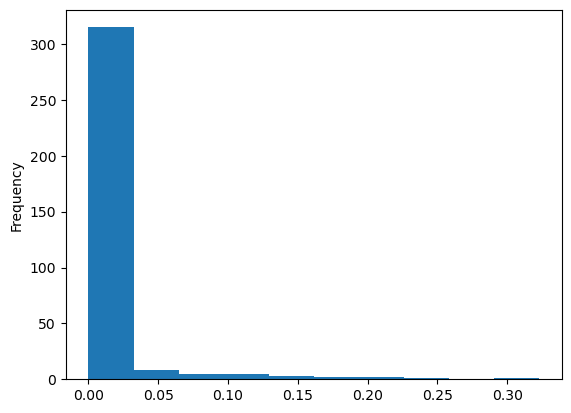

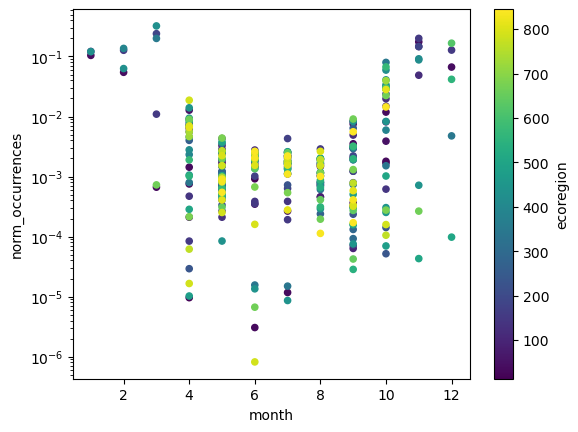

In [8]:
## Look at the data

# Histogram
occurrence_df.norm_occurrences.plot.hist()

# Scatterplot
occurrence_df.reset_index().plot.scatter(
    x = 'month',
    y = 'norm_occurrences',
    c = 'ecoregion',
    logy = True
)


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="f13606e9" class="cell" data-execution_count="9">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store occurrence_df</span></code></pre></div>
</div></div></div>

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [9]:
%store occurrence_df gbif_ecoregion_gdf

Stored 'occurrence_df' (DataFrame)
Stored 'gbif_ecoregion_gdf' (DataFrame)


In [10]:
gbif_ecoregion_gdf

,ecoregion,month
12,13.0,5
12,13.0,5
12,13.0,6
12,13.0,7
12,13.0,6
...,...,...
839,845.0,9
839,845.0,9
839,845.0,9
839,845.0,9


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!